# GlounTS Tutorial

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **GluonTS** for time series modeling  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
# -----------------------------------------------------------
# 📦 Imports: Required Libraries for Forecasting Experiments
# -----------------------------------------------------------

# --- Data Manipulation and Numerical Computation ---
import os  # For interacting with the operating system (e.g., file paths)
import pandas as pd  # For handling tabular data
import numpy as np  # For numerical operations on arrays

# --- Data Loading and Preprocessing ---
from datasets import load_dataset  # Hugging Face datasets library for standardized data loading
from genai4t.data.processing import dataset_to_pandas  # Custom utility to convert Hugging Face datasets to pandas DataFrames

# --- Configuration Management and Utilities ---
from omegaconf import OmegaConf  # Hydra-compatible tool for managing experiment configurations
from genai4t.utils import get_torch_device, set_random_state  # Helpers for device selection and reproducibility

# --- Forecasting Model Utilities ---
from genai4t.model.utils import fit_model  # Function to train GluonTS-based models
from genai4t.forecasting.util import create_predictions_dataframe  # Converts model outputs into a pandas DataFrame format
from gluonts.model.forecast import SampleForecast  # GluonTS forecast object used for evaluating model predictions

# --- Visualization ---
from matplotlib import pyplot as plt  # For plotting time series and forecasts
from genai4t.plot_style import plot_style # For plotting style

# --- Miscellaneous ---
from itertools import islice  # Useful for slicing iterables (e.g., previewing data)
from typing import List  # Type hinting support

In [2]:
import warnings

# Suppress FutureWarning from deprecated Period[B] usage in GluonTS dependencies.
# This will be addressed in a future GluonTS/pandas compatibility update.
warnings.filterwarnings(
    action='ignore',
    category=FutureWarning,
    message=r".*Use a DatetimeIndex.*"
)

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [3]:
ENV_CONFIG = {
        # Whether to use GPU acceleration if available
        # Set to True to enable GPU usage for faster training
        # Will fall back to CPU if GPU is not available
        "use_cuda": True,
        
        # Set random seed for reproducibility
        # Using a fixed seed ensures you get the same results each time you run the code
        # Change this value to get different but still reproducible results
        "random_state": 2024
    }

DATA_CONFIG = {
        # Name of the dataset to load from HuggingFace hub
        # This dataset contains exchange rate data
        "name": "camaron-ai/genai4t_exchange_rate",

        # Date to split data into training and test sets
        # Data before this date will be used for training
        # Data after this date will be used for testing
        "split_date": "2016-01-01",

        # Number of future time steps to predict
        # Model will forecast 31 days ahead
        "prediction_length": 31,

        # Number of past time steps to use for making predictions
        # Model will look at 30 days of history
        "context_length": 30,

        # Number of sample paths to generate for probabilistic forecasting
        # Higher values give better uncertainty estimates but take longer
        "num_samples": 20,

        # Frequency of the time series data
        # 'B' means business days (Monday-Friday)
        "freq": 'B',

        # Number of time series to process simultaneously during training
        # Larger batch sizes can speed up training but use more memory
        "batch_size": 32,
    
        # Number of batches in an epoch
        "num_batches_per_epoch": 50,
    }

In [4]:
# --------------------------------------------
# Load Configuration and Set Up Environment
# --------------------------------------------

# Select computation device: GPU (if available) or CPU
device = get_torch_device()

# Set random seed for reproducibility
# Ensures consistent results across multiple runs
set_random_state(ENV_CONFIG["random_state"])

Seed set to 2024


## Load Data

For this experiment, we’ll use the **Exchange Rate** dataset—a multivariate time series dataset commonly used in academic benchmarks for forecasting models.

This dataset was one of the benchmarks used in the evaluation of the **Chronos** paper, and is originally available through the Hugging Face Datasets Hub:

🔗 [Original Source (Chronos)](https://huggingface.co/datasets/autogluon/chronos_datasets/viewer/exchange_rate)

To make access easier and ensure long-term reproducibility, a **copy of the dataset has been published in the Hugging Face repo associated with this book**. We'll load it directly from there.

While we use the Exchange Rate dataset here, the methods in this notebook work with **any dataset in wide time series format** (i.e., one time series per column) with minimal adjustments.

In [5]:
# ------------------------------------------------------
# Import GluonTS Utilities for Data Transformation
# ------------------------------------------------------

from gluonts.dataset.split import split  # Split data into training and test sets
from gluonts.dataset.pandas import PandasDataset  # Convert pandas DataFrame to GluonTS dataset format
from gluonts.evaluation.backtest import _to_dataframe  # Convert forecasts back to DataFrame format
from gluonts.dataset.field_names import FieldName  # Enum of GluonTS field names
from gluonts.dataset.loader import TrainDataLoader  # Data loader used during training
from gluonts.itertools import Cached  # Caching wrapper for iterable datasets
from gluonts.torch.batchify import batchify  # Utility to create training batches from datasets
from gluonts.transform import (
    InstanceSplitter,  # Splits time series into overlapping training instances
    ExpectedNumInstanceSampler,  # Controls how many instances to sample per time series
)
from gluonts.dataset.util import to_pandas  # Convert GluonTS dataset entries back to pandas

In [6]:
# ------------------------------------------------------
# Load Dataset from Hugging Face and Convert to Pandas
# ------------------------------------------------------

# Load dataset split from the Hugging Face hub
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
data = dataset_to_pandas(dataset).asfreq(DATA_CONFIG["freq"])

# Display the first few rows of the DataFrame
data.head()

,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
timestamp,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
1990-01-04,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
1990-01-05,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


## Convert to GluonTS Format

To use GluonTS models, we need to convert our pandas DataFrame into a **GluonTS-compatible dataset**.

In this format, each time series (i.e., each column in the original DataFrame) becomes an individual **item**, described by:

- `target`: The sequence of observed values
- `start`: The timestamp of the first observation in the series
- `item_id`: An identifier for the time series (e.g., the column name in the DataFrame)

In [7]:
# Convert the pandas DataFrame to a GluonTS-compatible dataset
ds = PandasDataset(dict(data))
ds

PandasDataset<size=8, freq=B, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

Each `entry` in our GluonTS dataset is a dictionary with the fields shown below.
Let's print the first one to verify the structure.

In [8]:
# Print the structure of the first 3 item in the dataset
for entry in islice(ds, 3):
    print(entry.keys())

dict_keys(['start', 'target', 'item_id'])
dict_keys(['start', 'target', 'item_id'])
dict_keys(['start', 'target', 'item_id'])


In [9]:
# Ensure we have one GluonTS entry per time series
assert len(ds) == len(data.columns)

## Split the Dataset into Train/Test

The `split` function from GluonTS allows us to divide the time series data into two parts:

1. **Training Dataset**:  
   Contains data **up to** the configured `split_date`. It retains the same structure as the original dataset.

2. **Test Generator**:  
   Produces multiple **test windows** by sliding over the data. Each test window consists of:
   
   - **Input**: A window of historical context used for making predictions  
   - **Label**: The actual future values to compare against the model’s forecast

This setup enables evaluation across **multiple rolling forecast periods**.

We can configure:
- `prediction_length`: Forecast horizon (e.g., 31 days)
- `windows`: How many test instances to generate
- `distance`: The stride between each test window (allows overlap or gaps)

For more, see the [GluonTS tutorial on dataset splitting](https://ts.gluon.ai/stable/tutorials/data_manipulation/dataset_splitting_example.html).

In [10]:
# --------------------------------------------------------
# Demo: Generate and Visualize Test Forecast Windows
# --------------------------------------------------------

# demo dataset to show how splitting works
demo_data = data.loc["2015-10-01": "2016-06-01"]
demo_ds = PandasDataset(dict(demo_data))

# Convert the split date to a Period object (aligned with business day frequency)
test_split_date = pd.Period(DATA_CONFIG["split_date"], freq=DATA_CONFIG["freq"])

# Perform the dataset split with the demo data
demo_train_ds, demo_test_gen = split(demo_ds, date=test_split_date)

# Generate a small demo batch of test instances (3 windows, each predicting prediction_length days ahead)
demo_test_ds = demo_test_gen.generate_instances(
    prediction_length=DATA_CONFIG['prediction_length'],
    windows=3,
)

The plot below shows how the test generator creates rolling forecast windows:
- The **blue line** represents the time series
- the **green section** represents the historical context used by the model
- The **purple section** shows the future values the model is expected to predict

This structure is repeated for multiple test windows

In [11]:
from genai4t.forecasting.data import plot_dataset_splitting

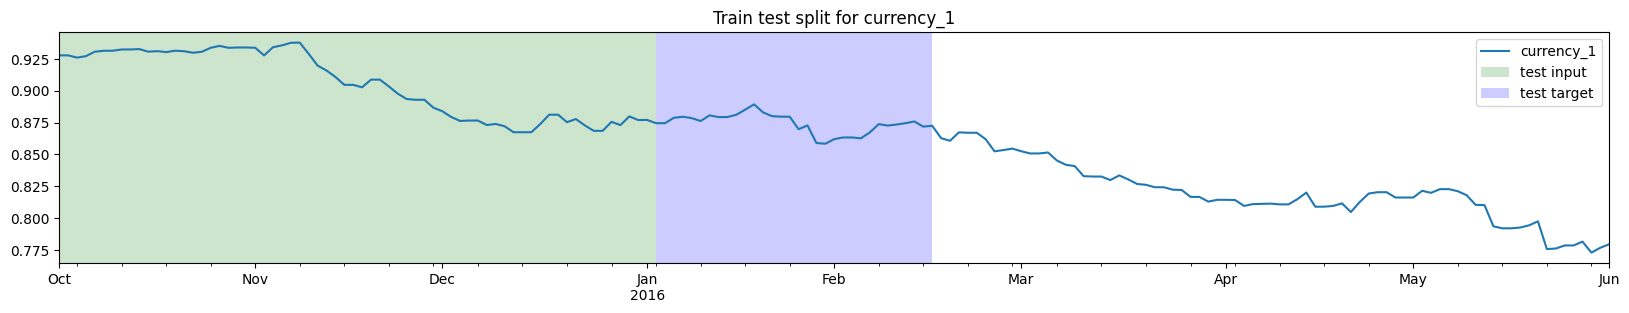

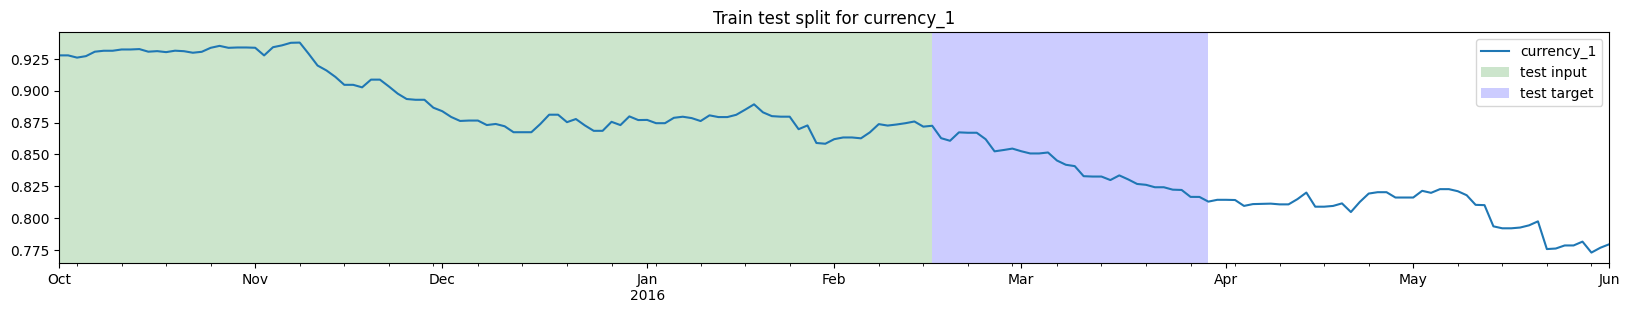

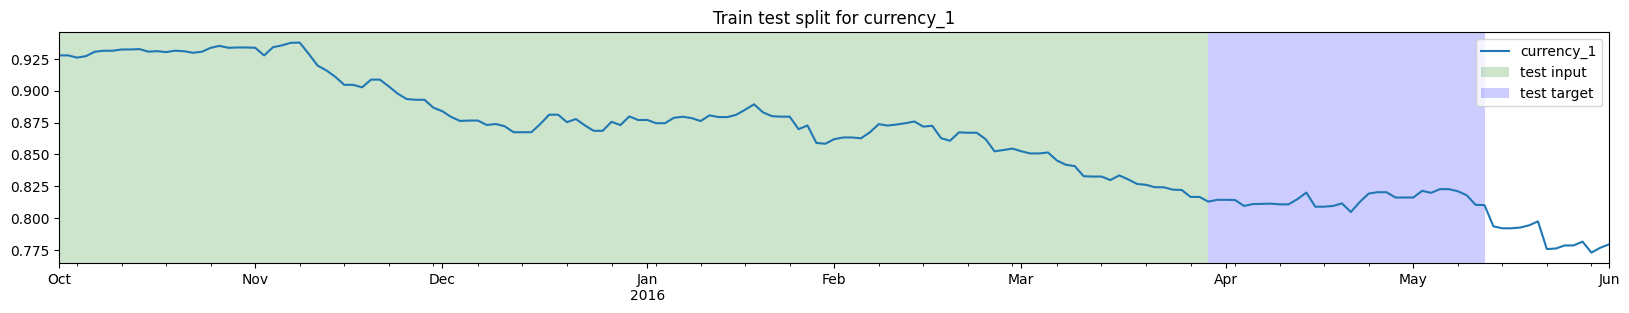

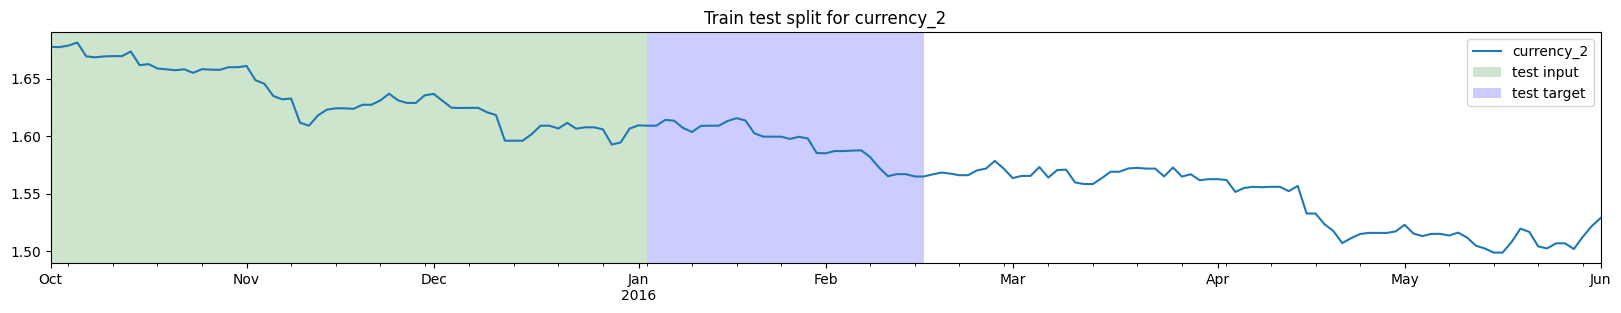

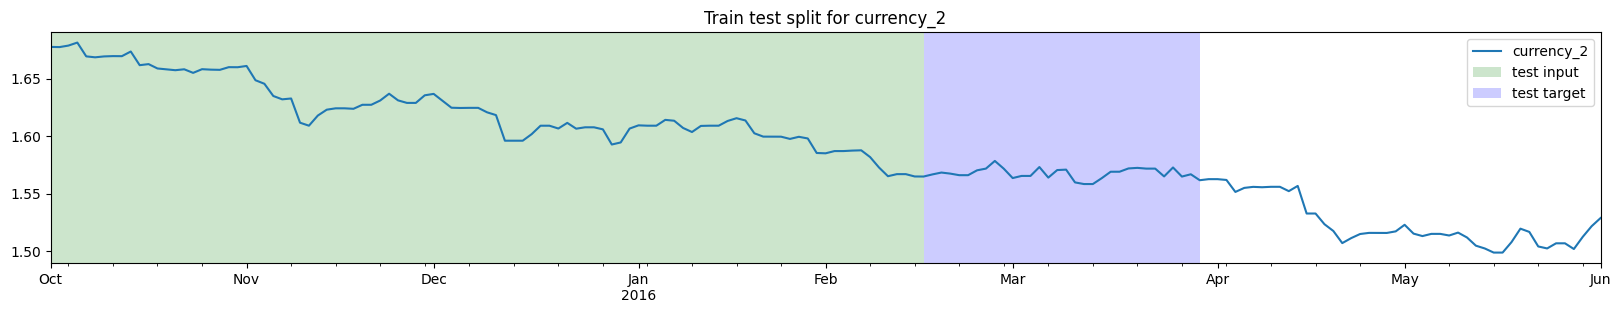

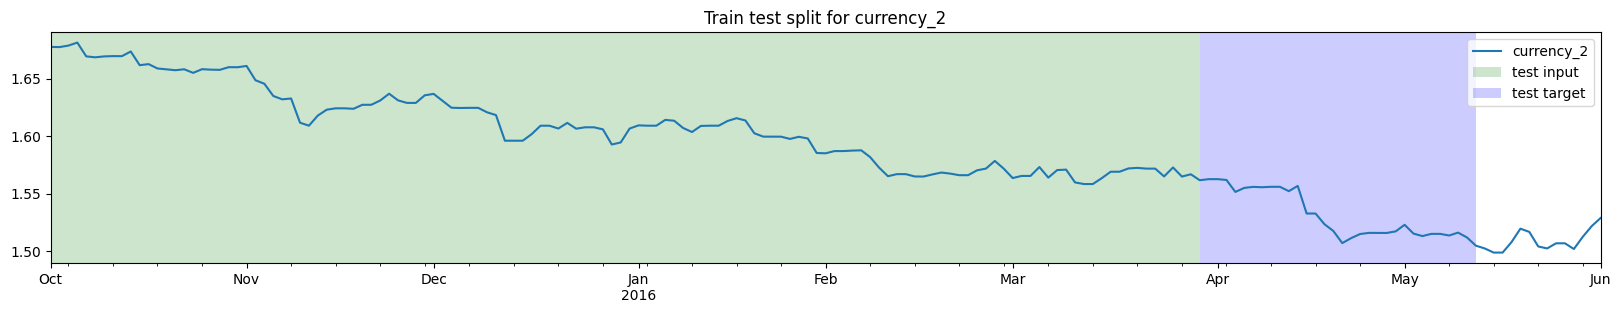

In [12]:
plot_dataset_splitting(demo_ds, demo_test_ds)

In [13]:
# ---------------------------------------------------
# Generate All Test Instances for Final Evaluation
# ---------------------------------------------------

# Perform the actual dataset split
train_ds, test_gen = split(ds, date=test_split_date)

# Calculate how many rolling windows we can generate
n_windows = len(data) - data.index.get_loc(DATA_CONFIG["split_date"]) - DATA_CONFIG["prediction_length"]
print(f"Number of evaluation windows: {n_windows}")

# Generate the test dataset (rolling windows over the full test range)
test_ds = test_gen.generate_instances(
    prediction_length=DATA_CONFIG["prediction_length"],
    windows=n_windows,
    distance=1  # Step size between test windows (1 = fully overlapping)
)

Number of evaluation windows: 773


In [14]:
# Preview the first few input sequences (historical context) used for forecasting
for i, x in enumerate(islice(test_ds.input, 2), 1):
    print(f"Test input window {i}:\n", to_pandas(x).tail())

Test input window 1:
 2015-12-28    0.875580
2015-12-29    0.873019
2015-12-30    0.879856
2015-12-31    0.876962
2016-01-01    0.877078
Freq: B, dtype: float32
Test input window 2:
 2015-12-29    0.873019
2015-12-30    0.879856
2015-12-31    0.876962
2016-01-01    0.877078
2016-01-04    0.874508
Freq: B, dtype: float32


In [15]:
# Preview the corresponding labels (future values to predict)
for i, y in enumerate(islice(test_ds.label, 2), 1):
    print(f"Target values (forecast horizon) {i}:\n", to_pandas(y).head())

Target values (forecast horizon) 1:
 2016-01-04    0.874508
2016-01-05    0.874508
2016-01-06    0.878735
2016-01-07    0.879585
2016-01-08    0.878503
Freq: B, dtype: float32
Target values (forecast horizon) 2:
 2016-01-05    0.874508
2016-01-06    0.878735
2016-01-07    0.879585
2016-01-08    0.878503
2016-01-11    0.876194
Freq: B, dtype: float32


## Setting Up the Training DataLoader

To train our forecasting model, we need to break each time series into smaller samples.  
Each sample — or **instance** — is split into two parts:

- **Past context window**: The historical values the model uses as input  
- **Future prediction window**: The values the model is trained to predict  

GluonTS handles this slicing using the `InstanceSplitter` class, which automatically generates training instances from the raw time series.

We also use an **instance sampler** (in this case, `ExpectedNumInstanceSampler`) to control how many slices are extracted per time series — useful when working with long series or limited data.

Finally, the `TrainDataLoader` wraps everything together, handling batching and efficient sampling during training.

In [16]:
# -------------------------------------------------------
# Create Instance Splitter and Training DataLoader
# -------------------------------------------------------

# Define how to split time series into training instances
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,             # Raw time series values
    is_pad_field=FieldName.IS_PAD,             # Indicates padded values in sequences
    start_field=FieldName.START,               # Start timestamp of the series
    forecast_start_field=FieldName.FORECAST_START,  # Start of the prediction window

    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,  # Number of instances to sample per time series
        min_future=DATA_CONFIG["prediction_length"]  # Minimum future length required
    ),

    past_length=DATA_CONFIG["context_length"],     # Input context length
    future_length=DATA_CONFIG["prediction_length"] # Forecast horizon
)

In [17]:
# Wrap the dataset with a training data loader
train_dl = TrainDataLoader(
    dataset=Cached(train_ds),                   # Cache dataset for performance
    batch_size=DATA_CONFIG["batch_size"],          # Batch size for training
    stack_fn=batchify,                          # Combine instances into tensors
    transform=training_splitter,                # Preprocessing transformation
    num_batches_per_epoch=DATA_CONFIG['num_batches_per_epoch'] # Limit batches per epoch
)

### Inspect a Sample Batch

Let’s explore a single batch produced by the training `DataLoader`.

Each batch is a dictionary. Key fields include:

- `past_target`: The input values (context window)
- `future_target`: The target values (forecast horizon)

These tensors will be fed into the model during training.

In [18]:
# Fetch a single batch from the DataLoader
batch = next(iter(train_dl))

In [19]:
# View the available fields in a training batch
batch.keys()

dict_keys(['start', 'item_id', 'past_target', 'future_target', 'past_is_pad', 'forecast_start'])

In [20]:
# Input sequence used by the model (shape: batch_size x context_length)
batch["past_target"]

tensor([[0.7842, 0.7860, 0.7846, 0.7857, 0.7871, 0.7818, 0.7844, 0.7803, 0.7799,
         0.7790, 0.7776, 0.7728, 0.7703, 0.7750, 0.7741, 0.7768, 0.7795, 0.7792,
         0.7788, 0.7780, 0.7764, 0.7795, 0.7807, 0.7838, 0.7830, 0.7838, 0.7791,
         0.7788, 0.7835, 0.7834],
        [0.7749, 0.7732, 0.7758, 0.7766, 0.7800, 0.7810, 0.7764, 0.7720, 0.7741,
         0.7838, 0.7854, 0.7867, 0.7862, 0.7857, 0.7897, 0.7888, 0.7920, 0.7932,
         0.7926, 0.7882, 0.7860, 0.7836, 0.7736, 0.7735, 0.7760, 0.7764, 0.7808,
         0.7828, 0.7878, 0.7861],
        [1.7453, 1.7340, 1.7155, 1.6980, 1.6969, 1.7030, 1.6937, 1.6875, 1.6710,
         1.6688, 1.6615, 1.6445, 1.6377, 1.6252, 1.6115, 1.6325, 1.6312, 1.6310,
         1.6420, 1.6281, 1.6395, 1.6320, 1.6180, 1.6140, 1.6015, 1.6057, 1.6150,
         1.6280, 1.6220, 1.6210],
        [0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208,
         0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208,
       

In [21]:
# Target sequence the model is trained to predict (shape: batch_size x prediction_length)
batch["future_target"]

tensor([[0.7825, 0.7824, 0.7765, 0.7715, 0.7565, 0.7590, 0.7603, 0.7605, 0.7565,
         0.7594, 0.7575, 0.7600, 0.7603, 0.7507, 0.7515, 0.7520, 0.7550, 0.7548,
         0.7540, 0.7598, 0.7630, 0.7631, 0.7641, 0.7650, 0.7645, 0.7650, 0.7670,
         0.7675, 0.7670, 0.7651, 0.7643],
        [0.7885, 0.7957, 0.8006, 0.8015, 0.8013, 0.8083, 0.8060, 0.8096, 0.8066,
         0.8080, 0.8087, 0.8173, 0.8130, 0.8187, 0.8169, 0.8255, 0.8249, 0.8278,
         0.8331, 0.8321, 0.8353, 0.8328, 0.8274, 0.8327, 0.8267, 0.8304, 0.8322,
         0.8285, 0.8253, 0.8172, 0.8210],
        [1.6070, 1.6505, 1.6515, 1.6440, 1.6525, 1.6660, 1.6910, 1.6810, 1.6835,
         1.6938, 1.6875, 1.6743, 1.6798, 1.6845, 1.6735, 1.6945, 1.7095, 1.7120,
         1.7128, 1.7000, 1.6950, 1.6983, 1.6935, 1.6875, 1.6880, 1.6620, 1.6300,
         1.6377, 1.6765, 1.6970, 1.6715],
        [0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208,
         0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208, 0.1208,

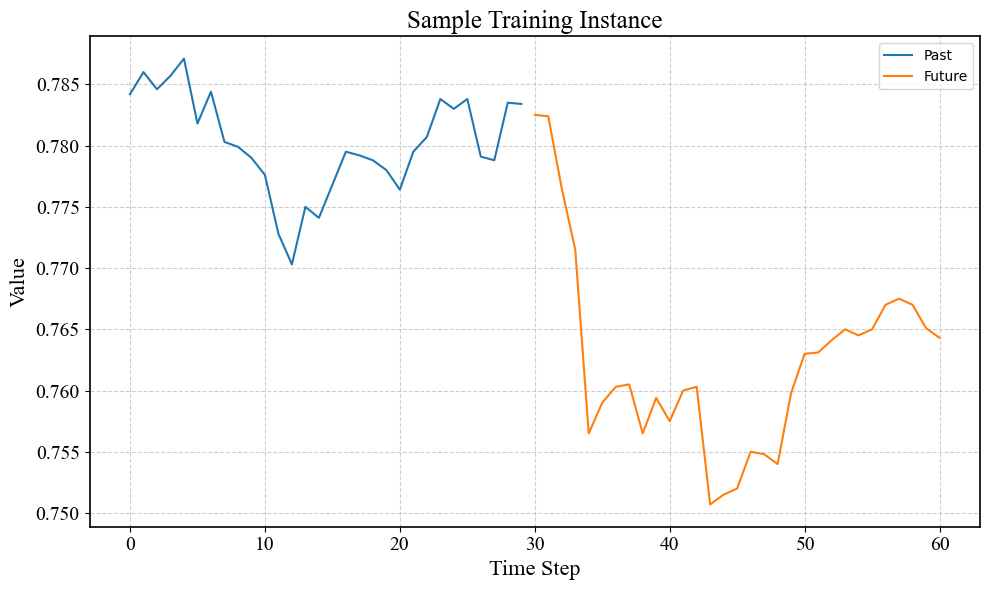

In [22]:
# Plot an example from the batch to visualize what the model sees

fig, ax = plt.subplots(figsize=plot_style.get_figsize("wide"))

# Plot past and future target values
past = batch['past_target'][0].numpy()
future = batch['future_target'][0].numpy()
x_future = np.arange(len(past), len(past) + len(future))

ax.plot(past, label="Past")
ax.plot(x_future, future, label="Future")

# Style
ax.set_title("Sample Training Instance")
ax.set_xlabel("Time Step")
ax.set_ylabel("Value")
ax.legend(loc="best")

plot_style.apply_plot_style(ax)   # boxed=True, tight_layout=True by default
plot_style.apply_grid(ax, "both")



## Model development

### GlountTS Model Development

According to the [GlounTS documentation](https://ts.gluon.ai/stable/getting_started/concepts.html):

the library is built around two core abstractions: `Estimator` and `Predictor`.

- A Predictor implements `.predict(..)` which, given some input time series, will return forecasts:
    ```python
    forecasts = predictor.predict(data)
    ```
- An Estimator is trained to produce a Predictor which then is used to make the actual predictions:

    ```python
    predictor = estimator.train(train_data)
    forecasts = predictor.predict(data)
    ```

Luckily, GluonTS provides an abstract class called `PyTorchLightningEstimator`, which integrates with `lightning` to simplify training PyTorch models.

### Define the Model

We'll start by defining our forecasting model. In this case, we'll use a simple MLP (Multi-Layer Perceptron) that predicts values from 1 up to `prediction_length` days into the future.

The model needs to be implemented as a `LightningModule`, which requires us to implement methods such as `training_step`, `validation_step`, and `configure_optimizers`. 

To simplify the process, most of our models inherit from `BaseLightningModule`, which already includes common functionality. That means we only need to implement two core methods:

1. `forward`: defines how the model processes the input.
2. `step`: shared logic used during training and validation.

In [23]:
from genai4t.model.core import BaseLightningModule
from torch import nn
import torch
from genai4t.forecasting.predictors.util import RobustScaler, BaseEstimator
from typing import Optional, Dict, Any


class NeuralARModel(BaseLightningModule):
    """A point-wise MLP model for time series forecasting.

    This model uses a simple MLP architecture to predict future values based on past observations.
    It includes robust scaling of the input data for normalization.

    Attributes:
        context_length (int): Number of past time steps used for prediction
        prediction_length (int): Number of future time steps to predict
        hidden_dim (int): Dimension of the hidden layer in the MLP
        lr (float): Learning rate for model training
        weight_decay (float): Weight decay (L2 penalty) for regularization
    """

    def __init__(
        self,
        context_length: int,
        prediction_length: int,
        hidden_dim: int,
        lr: float = 1e-3,
        weight_decay: float = 0.0,
    ):
        super().__init__(lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()

        self.mlp = nn.Sequential(
            nn.Linear(context_length, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, prediction_length),
        )
        self._loss = nn.MSELoss()
        self.prediction_length = prediction_length
        self.scaler = RobustScaler(keepdim=True)
        self.context_length = context_length

    def forward(self, past_target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            past_target (torch.Tensor): Input tensor of past time series values
                with shape (batch_size, context_length)

        Returns:
            torch.Tensor: Predicted future values with shape (batch_size, 1, prediction_length)
        """
        scaled_past_target, loc, scale = self.scaler(past_target)
        scaled_y: torch.Tensor = self.mlp(scaled_past_target)
        y: torch.Tensor = scaled_y * scale + loc
        y: torch.Tensor = y[:, torch.newaxis]
        return y

    def step(self, batch):
        """Compute the loss for a single training step.

        Args:
            batch: Dictionary containing 'past_target' and 'future_target' tensors

        Returns:
            torch.Tensor: MSE loss between predictions and ground truth
        """
        past_target = batch["past_target"]
        future_target = batch["future_target"][:, torch.newaxis]
        yhat = self.forward(past_target)
        assert yhat.shape == future_target.shape
        loss = self._loss(yhat, future_target)
        return loss

### NeuralAREstimator: Building a Custom Estimator

GluonTS provides a base class called `PyTorchLightningEstimator`, which simplifies training `PyTorch` models and returns a `Predictor` object compatible with the GluonTS inference API.

To use this class, we need to implement the following key methods:

`create_transformation`

Defines the transformation pipeline applied to the dataset. Transformations are typically used to preprocess the time series before training.
In this example, we don’t apply any transformation, so we return an `Identity()` transformation.

`create_lightning_module`

Instantiates the core forecasting model, in this case, `NeuralARModel`.

`create_predictor`

Wraps the trained model into a `PyTorchPredictor` that can be used for inference. This includes any necessary preprocessing (such as test-time instance splitting) to prepare the input for forecasting.

`create_training_data_loader`

Returns a dataloader for the training phase. This method uses a `TrainDataLoader` and an `InstanceSplitter` to generate training instances.

We'll reuse the same `InstanceSplitter` and configuration as shown in the earlier section on **Setting Up the Training DataLoader**.

`create_validation_data_loader`

Similar to the training dataloader, but used during validation. It prepares data for evaluating the model after or during training.



In [24]:
from gluonts.torch.model.estimator import PyTorchLightningEstimator
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.transform import (
    Chain,
    Identity,
    Transformation,
)
from typing import Optional, Dict, Any, Iterable
import lightning as L
from gluonts.dataset.loader import TrainDataLoader, InferenceDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.dataset.common import Dataset
from genai4t.forecasting.predictors.util import (
    get_prediction_splitter,
    get_training_splitter
)


class NeuralAREstimator(PyTorchLightningEstimator):
    """
    Estimator class for training and evaluating NeuralARModel.
    This estimator implements a simple autoregressive model for time series forecasting.
    It uses a neural network architecture to learn temporal patterns in the data and
    make predictions based on historical observations.

    Attributes:
        prediction_length (int): Number of time steps to predict into the future.
        context_length (int): Number of time steps used as input for making predictions.
        hidden_dim (int): Size of the hidden layer in the neural network.
        lr (float): Learning rate for the optimizer.
        weight_decay (float): Weight decay (L2 penalty) for the optimizer.
        batch_size (int): Number of samples per batch during training.
        num_batches_per_epoch (int): Number of batches to process in each training epoch.
        trainer_kwargs (Optional[Dict[str, Any]]): Additional arguments for the PyTorch Lightning trainer.
    """

    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dim: int,
        lr: float,
        weight_decay: float,
        batch_size: int,
        num_batches_per_epoch: int,
        trainer_kwargs: Optional[Dict[str, Any]] = None,
    ) -> None:
        super().__init__(trainer_kwargs=trainer_kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch

    def create_lightning_module(self) -> NeuralARModel:
        """Create and return a new instance of NeuralARModel with the estimator's configuration.

        Returns:
            NeuralARModel: A new instance of the autoregressive model
        """
        return NeuralARModel(
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            hidden_dim=self.hidden_dim,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )

    def create_transformation(self) -> Transformation:
        """Create the data transformation pipeline.

        Returns:
            Transformation: A chain of transformations to be applied to the input data.
            Currently returns an identity transformation (no transformation applied).
        """
        return Chain([Identity()])

    def create_predictor(
        self,
        transformation: Transformation,
        trained_model: L.LightningModule,
    ) -> PyTorchPredictor:
        """Create a predictor for making forecasts with the trained model.

        Args:
            transformation: The data transformation pipeline to apply.
            trained_model: The trained PyTorch Lightning module.

        Returns:
            PyTorchPredictor: A configured predictor instance for making forecasts.
        """
        prediction_splitter = get_prediction_splitter(
            context_length=self.context_length,
            prediction_length=self.prediction_length)
        
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            input_names=["past_target"],
            prediction_net=trained_model,
            batch_size=self.batch_size,
            input_transform=transformation + prediction_splitter,
        )

    def create_training_data_loader(
        self,
        data: Dataset,
        module: L.LightningModule,
        **kwargs,
    ) -> Iterable:
        """Create a data loader for training the model.

        Args:
            data: The input dataset containing time series data.
            module: The PyTorch Lightning module being trained.
            **kwargs: Additional keyword arguments.

        Returns:
            Iterable: A data loader that provides batches of training data.
        """
        training_splitter = get_training_splitter(self.context_length, self.prediction_length)
        train_dl = TrainDataLoader(
            Cached(data),  # Cache dataset for faster training
            batch_size=self.batch_size,  # Number of samples per batch
            stack_fn=batchify,  # Function to combine samples into batches
            transform=training_splitter,  # Preprocessing transformation
            num_batches_per_epoch=self.num_batches_per_epoch,  # Number of batches per training epoch
        )
        return train_dl

    def create_validation_data_loader(
        self,
        data: Dataset,
        module: L.LightningModule,
        **kwargs,
    ) -> Iterable:
        """Create a data loader for model validation.

        Args:
            data: The input dataset containing time series data.
            module: The PyTorch Lightning module being validated.
            **kwargs: Additional keyword arguments.

        Returns:
            Iterable: A data loader that provides batches of validation data.
        """
        training_splitter = get_training_splitter(self.context_length, self.prediction_length)
        valid_dl = InferenceDataLoader(
            Cached(data),  
            batch_size=self.batch_size,
            stack_fn=batchify,  
            transform=training_splitter,
            num_batches_per_epoch=self.num_batches_per_epoch,
        )
        return valid_dl

####  Instantiate the Estimator

Let’s now create an instance of our `NeuralAREstimator`.

We’ll pass the context and prediction lengths from the `DATA_CONFIG`, and the rest of the model hyperparameters (like `hidden_dim`, `lr`, etc.) from `MODEL_CONFIG`.

In [25]:
MODEL_CONFIG = {
    "lr": 1e-3,
    "hidden_dim": 128,
    "num_steps": 10_000,
    "weight_decay": 0.,
    
}

In [26]:
estimator = NeuralAREstimator(
    context_length=DATA_CONFIG["context_length"],
    prediction_length=DATA_CONFIG["prediction_length"],
    trainer_kwargs={"max_epochs": -1, "max_steps": MODEL_CONFIG["num_steps"]},
    hidden_dim=MODEL_CONFIG['hidden_dim'],
    lr=MODEL_CONFIG['lr'],
    weight_decay=MODEL_CONFIG['weight_decay'],
    batch_size=DATA_CONFIG['batch_size'],
    num_batches_per_epoch=DATA_CONFIG['num_batches_per_epoch']
)

## Train the Model

Now that we’ve set up our estimator, it's time to train!

In [27]:
set_random_state(ENV_CONFIG["random_state"])
predictor = estimator.train(train_ds)

Seed set to 2024
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type       | Params | Mode 
-----------------------------------------

Training: |                                                                                                   …

/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Epoch 0, global step 50: 'train_loss' reached 0.00167 (best 0.00167), saving model to '/Users/Shared/genai-for-trading-and-am/chapter05/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.00084 (best 0.00084), saving model to '/Users/Shared/genai-for-trading-and-am/chapter05/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.00044 (best 0.00044), saving model to '/Users/Shared/genai-for-trading-and-am/chapter05/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss'

Epoch 119, global step 6000: 'train_loss' was not in top 1
Epoch 120, global step 6050: 'train_loss' was not in top 1
Epoch 121, global step 6100: 'train_loss' was not in top 1
Epoch 122, global step 6150: 'train_loss' was not in top 1
Epoch 123, global step 6200: 'train_loss' was not in top 1
Epoch 124, global step 6250: 'train_loss' was not in top 1
Epoch 125, global step 6300: 'train_loss' was not in top 1
Epoch 126, global step 6350: 'train_loss' was not in top 1
Epoch 127, global step 6400: 'train_loss' was not in top 1
Epoch 128, global step 6450: 'train_loss' was not in top 1
Epoch 129, global step 6500: 'train_loss' was not in top 1
Epoch 130, global step 6550: 'train_loss' was not in top 1
Epoch 131, global step 6600: 'train_loss' was not in top 1
Epoch 132, global step 6650: 'train_loss' was not in top 1
Epoch 133, global step 6700: 'train_loss' was not in top 1
Epoch 134, global step 6750: 'train_loss' was not in top 1
Epoch 135, global step 6800: 'train_loss' was not in top

In [28]:
predictor

gluonts.torch.model.predictor.PyTorchPredictor(batch_size=32, device='auto', forecast_generator=gluonts.model.forecast_generator.SampleForecastGenerator(), input_names=['past_target'], input_transform=Chain(transformations=[gluonts.transform.split.InstanceSplitter(dummy_value=0.0, forecast_start_field='forecast_start', future_length=31, instance_sampler=PredictionSplitSampler(axis=-1, min_past=0, min_future=0, allow_empty_interval=False), is_pad_field='is_pad', lead_time=0, output_NTC=True, past_length=30, start_field='start', target_field='target', time_series_fields=[])]), lead_time=0, output_transform=None, prediction_length=31, prediction_net=NeuralARModel(
  (mlp): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=31, bias=True)
  )
  (_loss): MSELoss()
))

The following methods are common to all estimators covered in this book:

- `create_transformation`
- `create_predictor`
- `create_training_data_loader`
- `create_validation_data_loader`

Since their logic is the same across different models, we refactored this functionality into the `BaseEstimator` class located in `genai4t.forecasting.predictors.util`.

By inheriting from this class, we only need to implement the `create_lightning_module` method for each new model. This significantly reduces boilerplate and helps us stay focused on the core model design, while keeping the training and inference pipeline consistent across implementations.

## 📈 Inference and Evaluation

With the trained model wrapped in a `Predictor`, we can now:

1. Generate forecasts for the test set  
2. Visualize predictions vs. actual values  
3. Evaluate model performance using standard metrics

Let’s go through each of these steps.


In [29]:
# Generate probabilistic forecasts for the test input

forecasts: List[SampleForecast] = list(predictor.predict(
    test_ds.input,
    num_samples=DATA_CONFIG["num_samples"] # Number of forecast samples for uncertainty estimation
))

In [30]:
# Inspect the first forecast object
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id='currency_1', samples=array([[0.87750745, 0.8782433 , 0.87871987, 0.8794725 , 0.87669784,
        0.87618226, 0.87551826, 0.8760923 , 0.8759339 , 0.8752895 ,
        0.87595683, 0.8767894 , 0.87415004, 0.875629  , 0.8760011 ,
        0.87742734, 0.87599957, 0.8762106 , 0.87759453, 0.87785655,
        0.8776492 , 0.8786568 , 0.8780458 , 0.87732613, 0.8778184 ,
        0.8780738 , 0.87830645, 0.87823766, 0.8775051 , 0.87769544,
        0.87889165],
       [0.87750745, 0.8782433 , 0.87871987, 0.8794725 , 0.87669784,
        0.87618226, 0.87551826, 0.8760923 , 0.8759339 , 0.8752895 ,
        0.87595683, 0.8767894 , 0.87415004, 0.875629  , 0.8760011 ,
        0.87742734, 0.87599957, 0.8762106 , 0.87759453, 0.87785655,
        0.8776492 , 0.8786568 , 0.8780458 , 0.87732613, 0.8778184 ,
        0.8780738 , 0.87830645, 0.87823766, 0.8775051 , 0.87769544,
        0.87889165],
       [0.87750745, 0.8782433 , 0.87871987, 0.8794725 , 0.87669

In [31]:
# Convert test data to pandas DataFrames for visualization
tss: List[pd.DataFrame] = list(map(_to_dataframe, test_ds))

In [32]:
# Preview the tail of the first time series
tss[0].tail()

,0
2016-02-09,0.872638
2016-02-10,0.873477
2016-02-11,0.874508
2016-02-12,0.875848
2016-02-15,0.871802


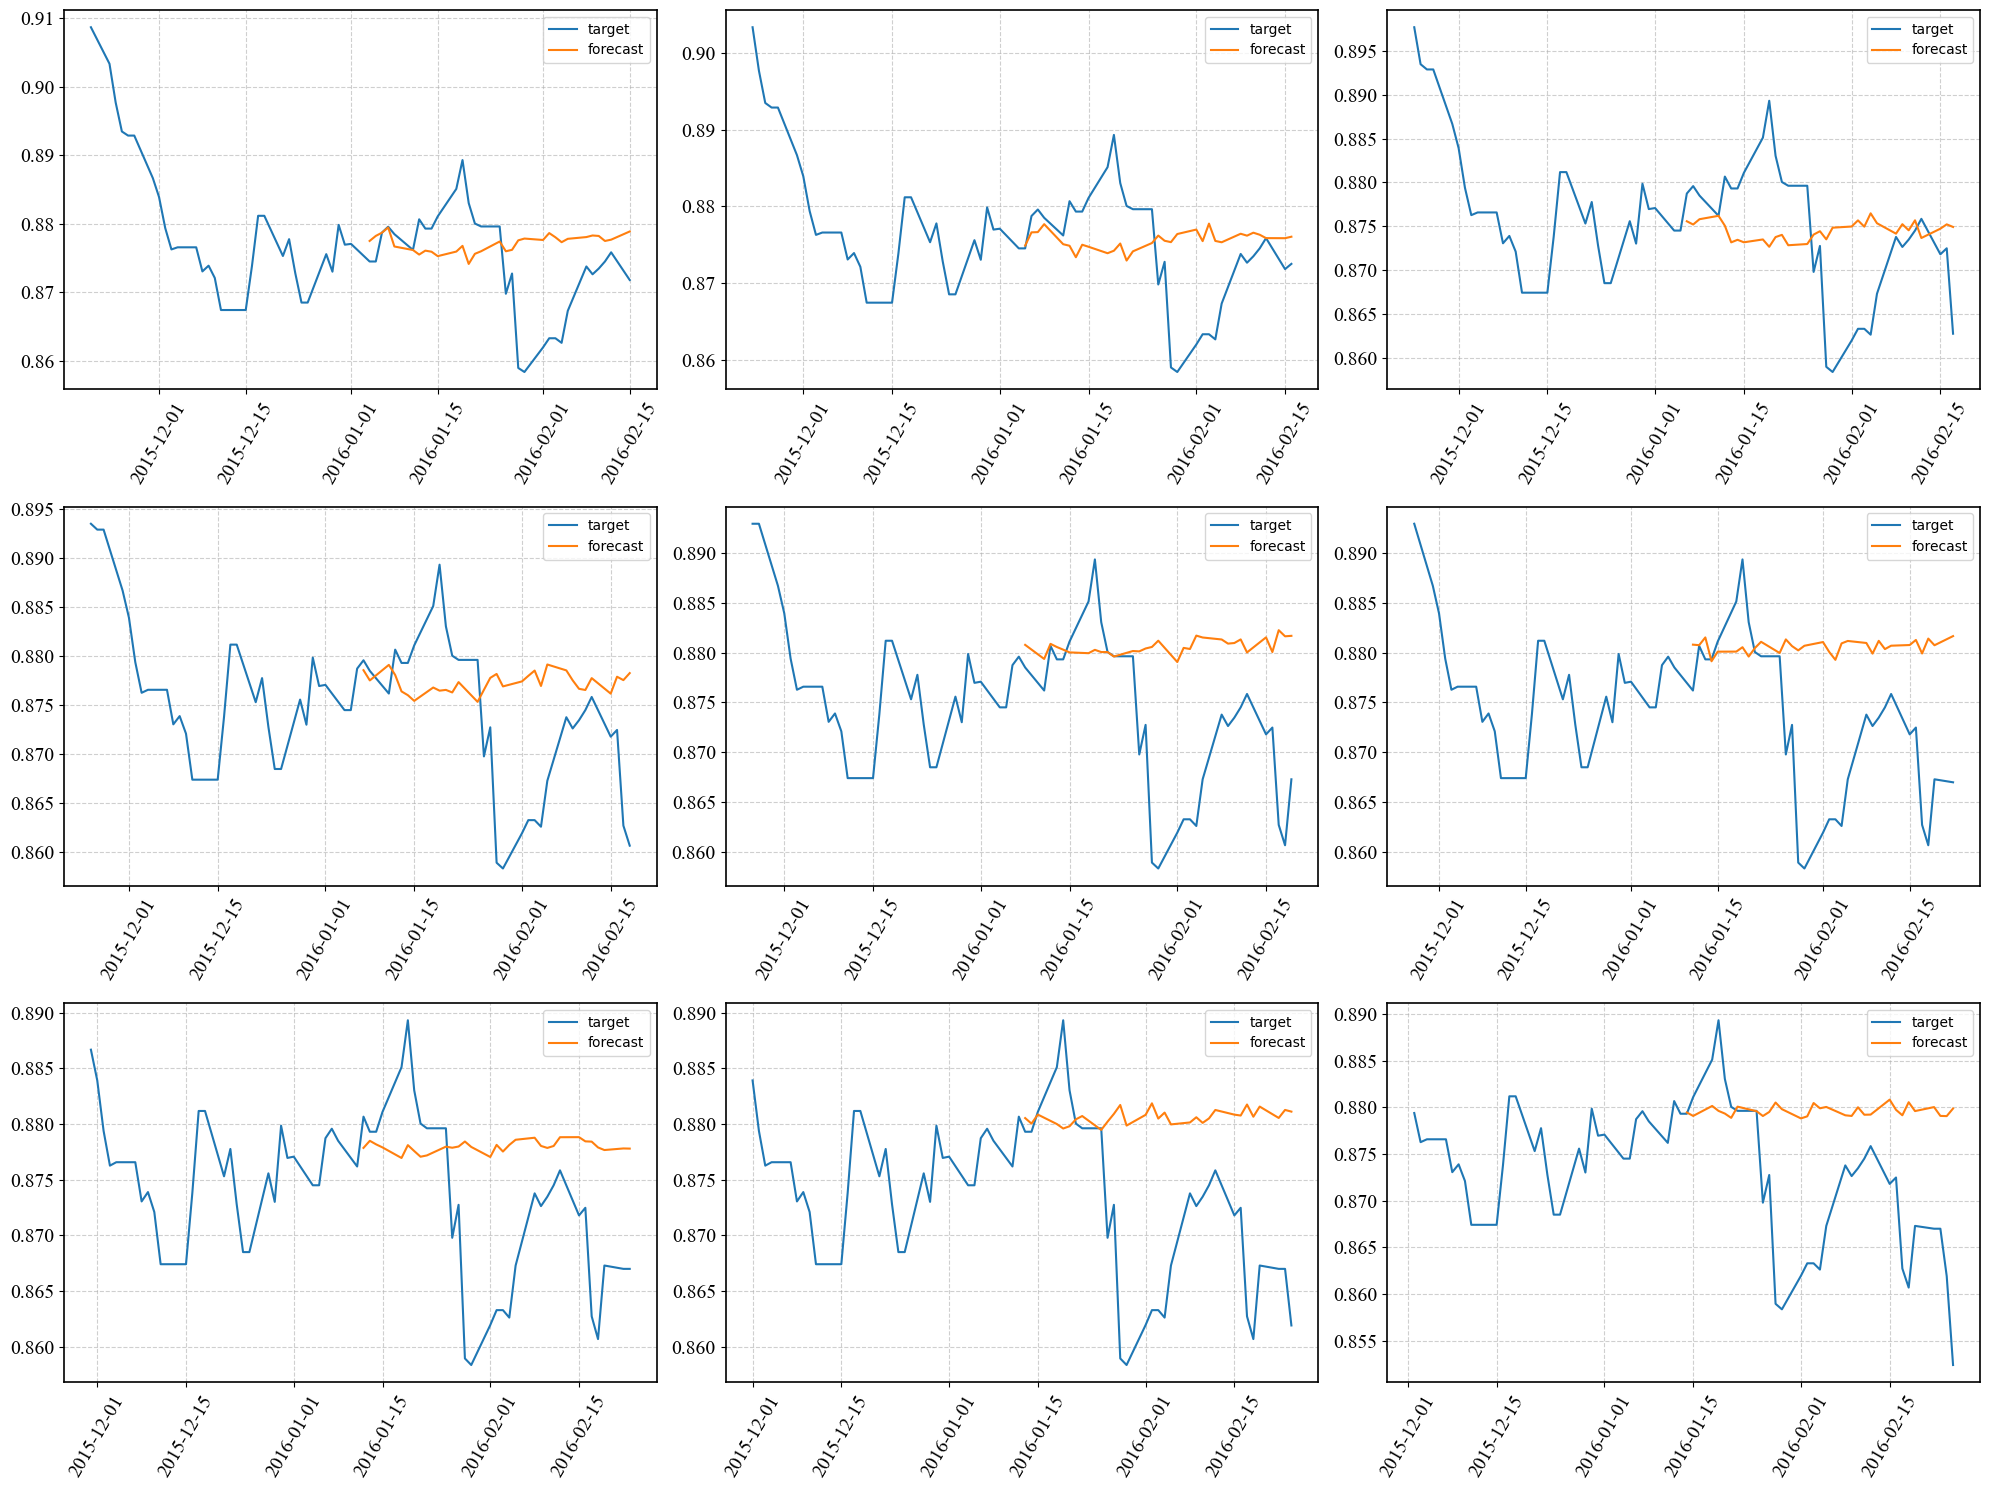

In [33]:
# Plot the first 9 time series with their forecasts
plt.figure(figsize=(20, 15))

# Plot the first 9 forecasts
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-2 * DATA_CONFIG["prediction_length"] :].to_timestamp(), label="target")  # Plot actual values
    forecast.plot(name="forecast")  # Plot forecast
    plt.xticks(rotation=60)
    ax.legend()
    # Apply styling
    plot_style.apply_plot_style(ax)
    plot_style.apply_grid(ax, axis="both")


GluonTS provides an `Evaluator` class that automatically compute a range of forecasting metrics. It takes as input a list of `Forecast` and the ground truth time series `tss` 

In [34]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
forecast_metrics_dict, _ = evaluator(tss, forecasts)
forecast_metrics = pd.DataFrame([forecast_metrics_dict])
forecast_metrics.T

Running evaluation: 6184it [00:00, 33827.50it/s]


,0
MSE,0.000345
abs_error,2097.977409
abs_target_sum,134581.574582
abs_target_mean,0.702028
seasonal_error,0.006400
MASE,1.917623
MAPE,0.014662
sMAPE,0.014616
MSIS,76.704915
num_masked_target_values,0.000000


The `create_predictions_dataframe` function takes each forecast and its corresponding input time series and returns a DataFrame with the following columns:

- `item_id`: Identifier of the time series
- `forecast`: Median forecast value for each future step
- `horizon`: Time step ahead (e.g., 1-step, 2-steps,...)
- `target`: Actual observed values

Since GluonTS produces probabilistic forecasts, we use the **median across forecast samples** as the point prediction.

In [35]:
# Build a DataFrame with forecasts and ground truth
pd_predictions = create_predictions_dataframe(data, forecasts)
pd_predictions.tail(10)  # Show last 10 predictions

,item_id,forecast,horizon,target
timestamp,,,,
2019-01-17,currency_8,0.703044,31,0.691009
2019-01-18,currency_8,0.702325,31,0.691133
2019-01-21,currency_8,0.698742,31,0.691133
2019-01-22,currency_8,0.699850,31,0.690978
2019-01-23,currency_8,0.702174,31,0.690164
2019-01-24,currency_8,0.702438,31,0.688565
2019-01-25,currency_8,0.702723,31,0.690288
2019-01-28,currency_8,0.702469,31,0.691419
2019-01-29,currency_8,0.699766,31,0.690942


In [36]:
# Import custom evaluation metrics
from genai4t.evaluation.metrics import compute_regression_scores

In [37]:
# Compute overall metrics (e.g., RMSE, MAE, MAPE)
compute_regression_scores(pd_predictions['target'], pd_predictions['forecast'])

{'MSE': 0.00034498260356485844,
 'MAE': 0.010943838395178318,
 'MAPE': 1.4661864377558231}

In [38]:
# Compute scores grouped by item and forecast horizon
item_scores = pd_predictions.groupby(['item_id', 'horizon']).apply(
    lambda df: pd.Series(compute_regression_scores(df["target"], df["forecast"])))

In [39]:
item_scores['MAPE'].unstack().T

item_id,currency_1,currency_2,currency_3,currency_4,currency_5,currency_6,currency_7,currency_8
horizon,,,,,,,,
1,0.489060,0.430565,0.401148,0.466198,0.114719,0.453854,0.561738,0.270711
2,0.650511,0.600077,0.554485,0.651706,0.160822,0.620408,0.758800,0.374613
3,0.800966,0.749032,0.676041,0.802215,0.190828,0.759945,0.895741,0.473304
4,0.933054,0.866314,0.788670,0.941316,0.220125,0.890583,1.023288,0.541237
5,1.051991,0.973452,0.886988,1.085315,0.243930,1.005050,1.142572,0.598985
6,1.147786,1.065376,0.955840,1.207528,0.267098,1.102121,1.236554,0.644684
7,1.244912,1.152365,1.023956,1.327925,0.289484,1.196655,1.322557,0.704418
8,1.308512,1.199964,1.074646,1.403038,0.311978,1.254777,1.381464,0.738680
9,1.416828,1.271517,1.140424,1.498048,0.337195,1.334780,1.456821,0.787886


In [40]:
# Filter predictions for 'currency_1' at the maximum forecast horizon
test = pd_predictions[(
    (pd_predictions['horizon'] == DATA_CONFIG["prediction_length"]) & (pd_predictions['item_id'] == 'currency_1')
)]

In [41]:
# Check the number of forecast points
test.shape

(773, 4)

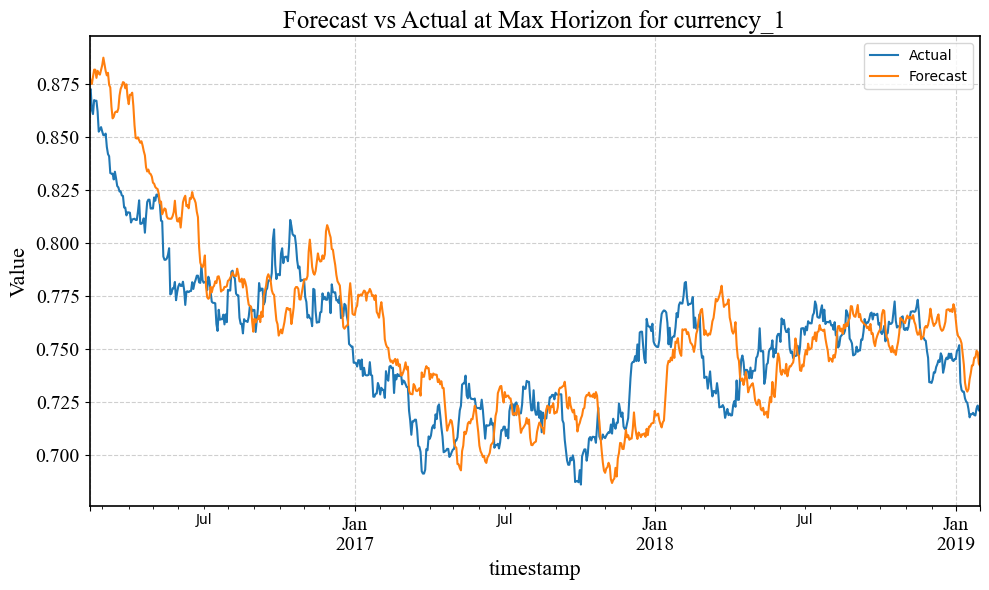

In [42]:
# Plot actual vs. forecast values
fig, ax = plt.subplots(figsize=plot_style.get_figsize("wide"))

test["target"].plot(ax=ax, label="Actual")
test["forecast"].plot(ax=ax, label="Forecast")

ax.set_title("Forecast vs Actual at Max Horizon for currency_1")
ax.set_xlabel("timestamp")  # or ax.set_xlabel("") to omit
ax.set_ylabel("Value")      # Customize based on your context
ax.legend()

# Apply styling
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax, axis="both")

In [43]:
# Compute metrics for this specific case
scores = compute_regression_scores(test["target"], test["forecast"])
scores

{'MSE': 0.0005517976824194193,
 'MAE': 0.019193530082702637,
 'MAPE': 2.548566460609436}